### imports

In [3]:
import polars as pl
from polars import col as c
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from catboost import CatBoostRegressor
import shap
import pandas as pd
from numpy.typing import ArrayLike, NDArray
import holidays

### constants

In [4]:
DATA_DIR = "dataset"
US_HOLIDAYS = holidays.US()  # this is a dict-like object

### functions

In [5]:
def mape_f(y_true: ArrayLike, y_pred: ArrayLike) -> np.floating:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    metric = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return round(metric, 2)

### data

In [6]:
path = os.path.join("../", DATA_DIR, "train_df.parquet")
train_df = pl.read_parquet(path)

path = os.path.join("../", DATA_DIR, "eval_df.parquet")
eval_df = pl.read_parquet(path)

path = os.path.join("../", DATA_DIR, "validation.parquet")
validation = pl.read_parquet(path)

path = os.path.join("../", DATA_DIR, "test.parquet")
test = pl.read_parquet(path)

In [8]:
train_df.sample()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_transport_median,shifted_week_rate
f64,f64,str,f64,datetime[μs],str,str,i8,i8,i8,i32,date,i64,i64,f64,f64,str,f64,f64
7.2573,4.600561,"""MKPFX""",19050.0,2019-12-12 10:42:00,"""NUTZC""","""GLVAR""",12,4,50,2019,2019-12-12,0,0,1.8962e6,191.380157,"""NUTZC_GLVAR""",8.0638,8.0638


### model

In [10]:
def xy_split(
    data: pl.DataFrame,
    target: str = "rate",
) -> tuple[pd.DataFrame, pd.DataFrame]:
    X = data.drop(
        [
            "date",
            "pickup_date",
            # "hour",
            # "kma_pair",
            # "origin_kma",
            # "destination_kma",
            target,
        ]
    ).to_pandas()
    y = data[target].to_pandas()
    return X, y

In [11]:
CATEGORICAL_FEATURES = [
    "transport_type",
    "origin_kma",
    "destination_kma",
    "kma_pair",
    "month",
    "weekday",
    "week",
    "year",
    "is_holiday",
    "is_holiday_next_week",
]

In [14]:
def fit_and_eval_catboost(
    train_df: pl.DataFrame,
    eval_df: pl.DataFrame,
    test_df: pl.DataFrame,
) -> CatBoostRegressor:

    X_train, y_train = xy_split(train_df)
    X_eval, y_eval = xy_split(eval_df)
    X_test, y_test = xy_split(test_df)

    model = CatBoostRegressor(
        random_seed=1984,
        cat_features=CATEGORICAL_FEATURES,
        eval_metric="MAPE",
        # loss_function="MAPE",
        depth=3,
        iterations=500,
        learning_rate=0.06,
        # thread_count=16,
        # used_ram_limit="128GB",
    )

    model.fit(
        X=X_train,
        y=y_train,
        early_stopping_rounds=50,
        verbose=True,
        eval_set=(
            X_eval,
            y_eval,
        ),
    )

    predicted = model.predict(X_test)
    predicted[predicted <= 0] = 0

    result_df = pd.DataFrame(
        {
            "preds": predicted,
            "fact": y_test,
        }
    )

    metric = mape_f(
        result_df.fact,
        result_df.preds,
    )
    print("CatBoost MAPE:", metric)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_train)
    shap.plots.beeswarm(shap_values, plot_size=(8, 5))
    plt.show()

    return model, result_df

0:	learn: 0.3817161	test: 0.3444222	best: 0.3444222 (0)	total: 112ms	remaining: 55.9s
1:	learn: 0.3646888	test: 0.3310520	best: 0.3310520 (1)	total: 163ms	remaining: 40.5s
2:	learn: 0.3481224	test: 0.3177433	best: 0.3177433 (2)	total: 221ms	remaining: 36.7s
3:	learn: 0.3330644	test: 0.3057260	best: 0.3057260 (3)	total: 298ms	remaining: 37s
4:	learn: 0.3186888	test: 0.2950288	best: 0.2950288 (4)	total: 402ms	remaining: 39.8s
5:	learn: 0.3050354	test: 0.2845909	best: 0.2845909 (5)	total: 504ms	remaining: 41.5s
6:	learn: 0.2929109	test: 0.2747421	best: 0.2747421 (6)	total: 837ms	remaining: 59s
7:	learn: 0.2812391	test: 0.2668149	best: 0.2668149 (7)	total: 969ms	remaining: 59.6s
8:	learn: 0.2699967	test: 0.2585356	best: 0.2585356 (8)	total: 1.05s	remaining: 57.4s
9:	learn: 0.2597111	test: 0.2508763	best: 0.2508763 (9)	total: 1.17s	remaining: 57.5s
10:	learn: 0.2502885	test: 0.2438325	best: 0.2438325 (10)	total: 1.25s	remaining: 55.5s
11:	learn: 0.2401421	test: 0.2365922	best: 0.2365922 (11

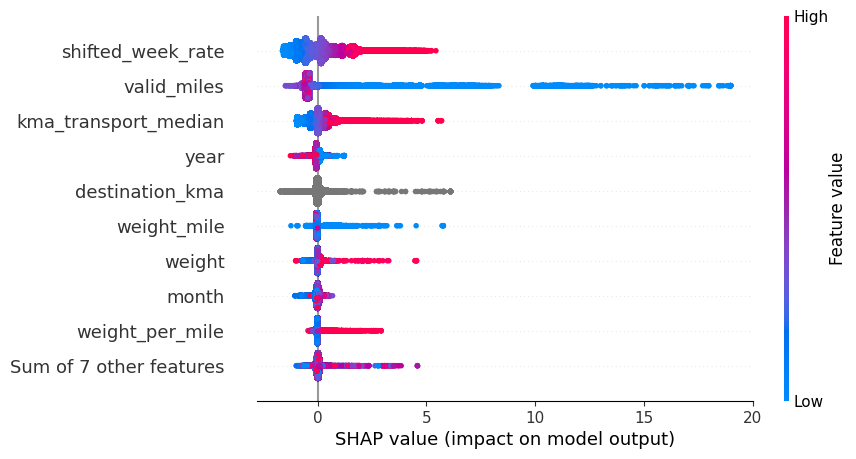

In [15]:
model, result_df = fit_and_eval_catboost(train_df, eval_df, validation)